In [2]:
import cv2
import matplotlib.pylab as plt
import numpy as np

# Resize with OpenCV

In [8]:
coarse_hr = plt.imread('coarse_test.png') # exported img from coarsen.ipynb
coarse_hr.shape

(484, 794, 4)

Resize so that each pixel is exactly 1 block

In [9]:
factor = 32 # orig image was 640x480 . this image is 25x15
downscaled_image = cv2.resize(coarse_hr, (coarse_hr.shape[1] // factor, coarse_hr.shape[0] // factor), interpolation=cv2.INTER_NEAREST)

In [10]:
downscaled_image.shape

(15, 24, 4)

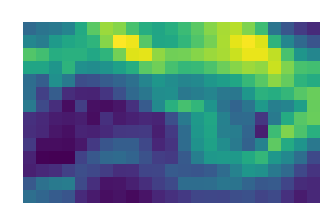

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(downscaled_image)
ax.axis('off')
plt.show()

In [12]:
bilinear = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_LINEAR)
bicubic = cv2.resize(downscaled_image, (200, 120), interpolation = cv2.INTER_CUBIC)

Plot example interpolation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


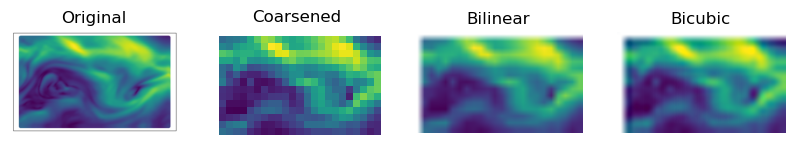

In [13]:
fig, axes = plt.subplots(1,4, figsize=(10,15))
orig = plt.imread('orig.png')
axes[0].imshow(orig)
axes[0].axis('off')
axes[0].set_title("Original")
axes[1].imshow(downscaled_image)
axes[1].axis('off')
axes[1].set_title("Coarsened")
axes[2].imshow(bilinear)
axes[2].axis('off')
axes[2].set_title("Bilinear")
axes[3].imshow(bicubic)
axes[3].axis('off')
axes[3].set_title("Bicubic")
plt.show()

# Resize directly from ERA data

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
t = np.load('ERA_wind.npz')

Pick a sample image, preprocess

In [16]:
lat = t.get('lat')[:120] # dropping the last pixel because it makes reshaping easier
lon = t.get('lon')[:200]
x_grid, y_grid = np.meshgrid(lon, lat, indexing='xy')
x_values = x_grid.flatten()
y_values = y_grid.flatten()
u = t.get('wind_u')[200][1][:120, :200]
v = t.get('wind_v')[200][1][:120, :200]

In [17]:
u.shape

(120, 200)

In [18]:
wind_speed = np.sqrt(u**2 + v**2)
# 120x200 wind speeds
wind_speed_flat = wind_speed.flatten()

Text(0.5, 1.0, 'Bicubic')

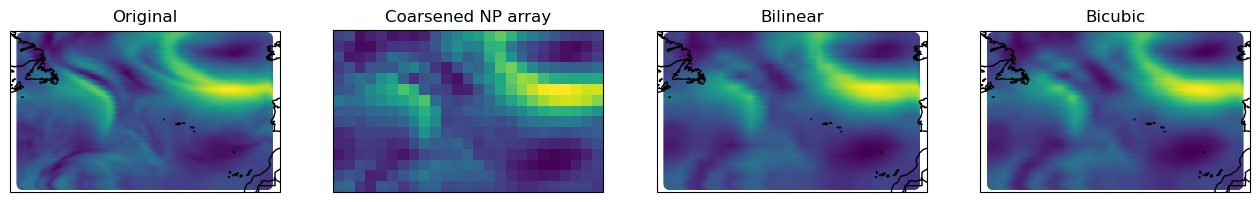

In [19]:
fig, axes = plt.subplots(1,4, figsize=(16,24), subplot_kw={'projection': ccrs.PlateCarree()})

# plot orig
scatter_plot = axes[0].scatter(x_values, y_values, c=wind_speed_flat, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[0].coastlines()
axes[0].add_feature(cfeature.BORDERS)
axes[0].set_title("Original")

# plot coarsened
coarse_wind = np.zeros((121 // 8, 201 // 8))
for i in range(0, 120, 8):
    for j in range(0, 200, 8):
        block = wind_speed[i:i+8, j:j+8]
        average = np.mean(block)
        coarse_wind[i // 8, j // 8] = average

axes[1].imshow(coarse_wind, cmap='viridis', interpolation='nearest')
axes[1].set_title('Coarsened NP array')

# plot bicubic, bilinear interpolations
bilinear = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_LINEAR)
scatter_plot = axes[2].scatter(x_values, y_values, c=bilinear, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[2].coastlines()
axes[2].add_feature(cfeature.BORDERS)
axes[2].set_title("Bilinear")

bicubic = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_CUBIC)
scatter_plot = axes[3].scatter(x_values, y_values, c=bicubic, cmap='viridis', s=50, transform=ccrs.PlateCarree())
axes[3].coastlines()
axes[3].add_feature(cfeature.BORDERS)
axes[3].set_title("Bicubic")

In [20]:
wind_speed.shape, coarse_wind.shape, bilinear.shape, bicubic.shape

((120, 200), (15, 25), (120, 200), (120, 200))

In [6]:
bilinear_data = np.zeros(shape = (149,200*120))
bicubic_data = np.zeros(shape = (149,200*120))
wind_speed_data = np.zeros(shape = (149,200*120))

for time in range(0,149):
    u = t.get('wind_u')[time+595][1][:120, :200]
    v = t.get('wind_v')[time+595][1][:120, :200]
    wind_speed = np.sqrt(u**2 + v**2)
    wind_speed_flat = wind_speed.flatten()
    wind_speed_data[time] = wind_speed_flat
    coarse_wind = np.zeros((121 // 8, 201 // 8))
    for i in range(0, 120, 8):
        for j in range(0, 200, 8):
            block = wind_speed[i:i+8, j:j+8]
            average = np.mean(block)
            coarse_wind[i // 8, j // 8] = average
    
    bilinear = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_LINEAR)
    bicubic = cv2.resize(coarse_wind, (200, 120), interpolation = cv2.INTER_CUBIC)
    bilinear_data[time] = bilinear.flatten()
    bicubic_data[time] = bicubic.flatten()

x = wind_speed_data.flatten() - bilinear_data.flatten()
print(x.shape)

mape_bilinear = (np.abs(wind_speed_data.flatten() - bilinear_data.flatten())/wind_speed_data.flatten()).mean(axis=0)
print(mape_bilinear)
mape_bicubic = (np.abs(wind_speed_data.flatten() - bicubic_data.flatten())/wind_speed_data.flatten()).mean(axis=0)
print(mape_bicubic)


    

(3576000,)
0.13724660810108924
0.09778524040676466


In [7]:
from metrics import *

mse_bilinear = (wind_speed_data.flatten(), bilinear_data.flatten())
js_dist = get_js_distance(wind_speed_data.flatten(), bilinear_data.flatten())
print(js_dist)

ModuleNotFoundError: No module named 'tensorflow'